In [1]:
#Importing Operational Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import PredefinedSplit
import sklearn.metrics as metrics

#Importing Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

#Importing Modeling libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay




#Silencing Warnings (This step should be done AFTER finishing the modeling, for viewing purposes only)
import warnings
warnings.filterwarnings("ignore")

## Importing Dataset

In [2]:
filepath = r'C:\Users\jrica\Downloads\Bank Customer Churn Prediction.csv'

In [3]:
df = pd.read_csv(filepath)

**Dropping unecessary columns:** we can't use customer_id to predict anything and would be unethical to make predictions based on gender, reason why we are dropping these two columns.

In [4]:
df = df.drop(['customer_id','gender'],axis=1)

Getting dummy variables for the categorical column 'Country', since the dataset is from an European bank.

In [5]:
df = pd.get_dummies(columns=['country'],data=df,drop_first=True)

In [6]:
df['churn'].value_counts(normalize=True)

churn
0    0.7963
1    0.2037
Name: proportion, dtype: float64

Since the dataset is imbalanced (20% churned vs 80% stayed), we need to stratify the samples using the Y variable. This is important to guarantee that the y will have a balanced amount of churned customers and, thus, will improve our predictions.

In [7]:
#Splitting the Groups
X = df.copy().drop(['churn'],axis=1)
y = df['churn']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20,stratify=y,random_state = 42)
X_tr,X_val,y_tr,y_val = train_test_split(X_train,y_train,test_size = 0.20,stratify=y_train,random_state = 42)

In [8]:
print('Train Dataset')
print('X: ' + str(X_tr.shape[0]))
print('y: ' + str(y_tr.shape[0]))
print('Validation Dataset')
print('X: ' + str(X_val.shape[0]))
print('y: ' + str(y_val.shape[0]))
print('Test Dataset')
print('X: ' + str(X_test.shape[0]))
print('y: ' + str(y_test.shape[0]))

Train Dataset
X: 6400
y: 6400
Validation Dataset
X: 1600
y: 1600
Test Dataset
X: 2000
y: 2000


#### Useful functions to retrieve the results:

In [9]:
#Logistic Regression
def test_scores(model_name, y_set,y_pred):
    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = metrics.f1_score(y_set,y_pred)
    recall = metrics.recall_score(y_set,y_pred)
    precision = metrics.precision_score(y_set,y_pred)
    accuracy = metrics.accuracy_score(y_set,y_pred)
  
    # Create table of results
    table = pd.DataFrame()
    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'F1': [f1],
                          'Recall': [recall],
                          'Precision': [precision],
                          'Accuracy': [accuracy]
                         }
                        )
  
    return table


#Random Forest and XGB

def rf_xgb_results_cv(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.
  
    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.  
    '''

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'F1': [f1],
                          'Recall': [recall],
                          'Precision': [precision],
                          'Accuracy': [accuracy]
                         }
                        )
  
    return table

## Logistic Regression

In [10]:
#Instantiate the Model and the Scaler
log_reg = LogisticRegression()
scaler = StandardScaler()

In [11]:
X_tr_lr = scaler.fit_transform(X_tr)
X_val_lr = scaler.fit_transform(X_val)

In [12]:
log_reg = log_reg.fit(X_tr_lr,y_tr)

## Random Forest

#### Instantiate the Random Forest Classifier

In [13]:
rf = RandomForestClassifier(random_state=0)

#### Create a dictionary of hyperparameters to tune and a list of the scoring metrics to capture

In [14]:
cv_parameters = {
    'max_depth': [2,3,4,5,None],
    'min_samples_leaf':[1,2,3],
    'min_samples_split':[2,3,4],
    'max_features':[2,3,4],
    'n_estimators':[25,50,75,100]
}

scoring = ['accuracy','precision','recall','f1']

#### Instantiate the GridSearchCV object

In [15]:
rf_cv = GridSearchCV(rf,cv_parameters,scoring=scoring,cv=5,refit='recall')

#### Fitting the model to the training data.

In [16]:
%%time
rf_cv.fit(X_tr,y_tr)

CPU times: total: 7min 30s
Wall time: 10min 12s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [2, 3, 4, 5, None],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [25, 50, 75, 100]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

#### Best Score and Hyperparameters

In [17]:
print('The best average score of all folds was: ' + str(rf_cv.best_score_))

The best average score of all folds was: 0.4731977600943118


In [18]:
print('The best hyperparameters combination was: ' + str(rf_cv.best_params_))

The best hyperparameters combination was: {'max_depth': None, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}


## XGBoost

#### Instantiate the XGBoost Classifier

In [19]:
xgb = XGBClassifier(objective='binary:logistic')

#### Create a dictionary of hyperparameters to tune

In [20]:
cv_parameters_xgb ={'max_depth': [3, 6, 9, 12],
             'min_child_weight': [1, 3, 5, 7],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [50, 100, 150, 300]
             }


#### Define a list of scoring metrics to capture

In [21]:
scoring = ['accuracy','precision','recall','f1']

#### Instantiate the GridSearchCV object

In [22]:
xgb_cv = GridSearchCV(estimator=xgb,
                     param_grid=cv_parameters_xgb,
                     scoring=scoring,
                     cv=5,
                     refit='recall'
                     )

#### Fitting the model to the train data

In [23]:
%%time
xgb_cv.fit(X_tr,y_tr)

CPU times: total: 13min 22s
Wall time: 1min 19s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [3, 6, 9, 12],
                         'min_child_weight': [1, 3, 5, 7],
                         'n_estimators': [50, 100, 150, 300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

#### Best Score and Hyperparameters

In [24]:
print('The best average score of all folds was: ' + str(xgb_cv.best_score_))

The best average score of all folds was: 0.496201002063071


In [25]:
print('The best hyperparameters combination was: ' + str(xgb_cv.best_params_))

The best hyperparameters combination was: {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 150}


## Model Selection

##### Using all three models to predict on the Validation Dataset

In [26]:
### YOUR CODE HERE ###
y_pred_rf = rf_cv.predict(X_val)
y_pred_xgb = xgb_cv.predict(X_val)
y_pred_lr = log_reg.predict(X_val_lr)

#### Results for Validation Dataset

##### The champion model will be selected to predict with the Test dataset

In [29]:
#Logistic Regression
log_reg_val = test_scores('Logistic Regression - Validation',y_val,y_pred_lr)

#Random Forest
results_rf_cv = rf_xgb_results_cv('Random Forest CV',rf_cv)
results_rf_val = test_scores('Random Forest CV - Validation Dataset',y_val,y_pred_rf)
                                  
#XGBoost
results_xgb_cv = rf_xgb_results_cv('XGBoost CV',xgb_cv)
results_xgb_val = test_scores('XGBoost CV - Validation Dataset',y_val,y_pred_xgb)

In [30]:
results = pd.concat([log_reg_val,results_rf_cv,results_rf_val,results_xgb_cv,results_xgb_val])

In [31]:
results.sort_values(by='Recall',ascending=False)

,Model,F1,Recall,Precision,Accuracy
0,XGBoost CV - Validation Dataset,0.580292,0.487730,0.716216,0.856250
0,XGBoost CV,0.586416,0.477026,0.762888,0.863281
0,Random Forest CV,0.576599,0.473198,0.739591,0.858594
0,Random Forest CV - Validation Dataset,0.570888,0.463190,0.743842,0.858125
0,Logistic Regression - Validation,0.300000,0.193252,0.670213,0.816250


In this case, we are using **Recall** to determine the champion model, since the purpose of the model is to predict if a customer will Churn the bank or not and we want to minimize False Negatives because there is a high cost associated with a customer leaving.

Just as a reminder:

* **Recall** measures the ability of a classification model to identify all relevant instances (true positives) among the total actual instances (sum of true positives and false negatives). It is useful when the cost of false negatives is high.
* **Precision** measures the accuracy of positive predictions made by the model. It is particularly important when the cost of false positives is high.
* **Accuracy** measures the overall correctness of the model across all classes. It is a general metric but can be misleading in imbalanced datasets.
* **F1 Score** is the harmonic mean of precision and recall. It provides a balance between precision and recall, making it suitable for situations where there is an uneven class distribution. F1 Score is often used when both false positives and false negatives are important, and you want to find a balance between precision and recall.

#### Using Champion Model to Predict and collect final results

In [32]:
y_pred_final = xgb_cv.predict(X_test)
results_xgb_final = test_scores('XGBoost CV - Test',y_pred_final,y_test)
results = pd.concat([results,results_xgb_final])

In [33]:
results.sort_values(by='Recall',ascending=False)

,Model,F1,Recall,Precision,Accuracy
0,XGBoost CV - Test,0.561404,0.693141,0.471744,0.850000
0,XGBoost CV - Validation Dataset,0.580292,0.487730,0.716216,0.856250
0,XGBoost CV,0.586416,0.477026,0.762888,0.863281
0,Random Forest CV,0.576599,0.473198,0.739591,0.858594
0,Random Forest CV - Validation Dataset,0.570888,0.463190,0.743842,0.858125
0,Logistic Regression - Validation,0.300000,0.193252,0.670213,0.816250


Great News! The recall with the champion model is even higher when using the Test dataset. This means that we not only choose the correct model, but also discard the overfit.

#### Verifying the Results with Confusion Matrix

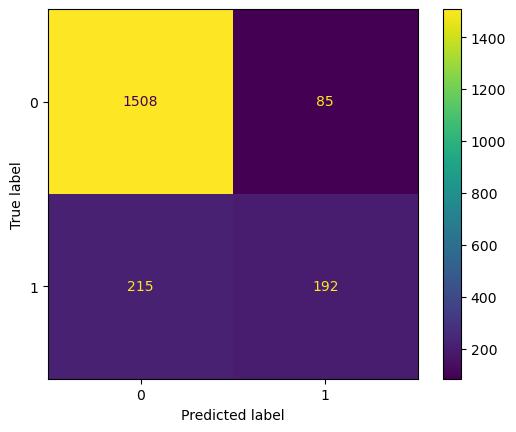

In [34]:
def cm_plot(model,x_data,y_data):
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data,model_pred,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot()
    plt.show()

cm_plot(xgb_cv,X_test,y_test)

In this case, we had 215 (10.75%) customers that churned but the model did not predict. Moreover, we predicted that 85 customers would churn but they stayed. These two groups sum up to 15%. If the bank wants to minimize churn, a good idea would be to focus on the aspects of this 15% of customers and proactively reach out to know their concerns, doubts, and complains.

This means that the model had **good results** and if the Bank wants to take actions to prevent customer churn, we ***could use this model*** in production

#### Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

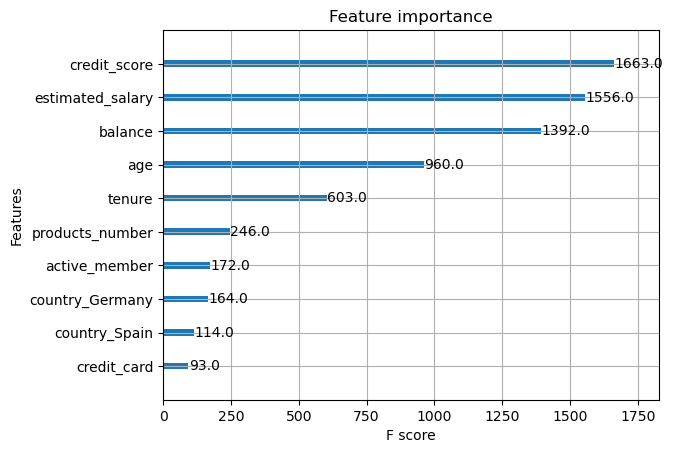

In [35]:
### YOUR CODE HERE ###
plot_importance(xgb_cv.best_estimator_)

Plotting the Feature Importance chart for any champion model is important to capture the variables that were able to predict the most results. In this case, credit score, estimated salary and available balance were the most important variables, so any churn-preventing actions that the bank wants to take should consider these aspects for each customer

Text(0.5, 1.0, 'Available Balance vs Churn')

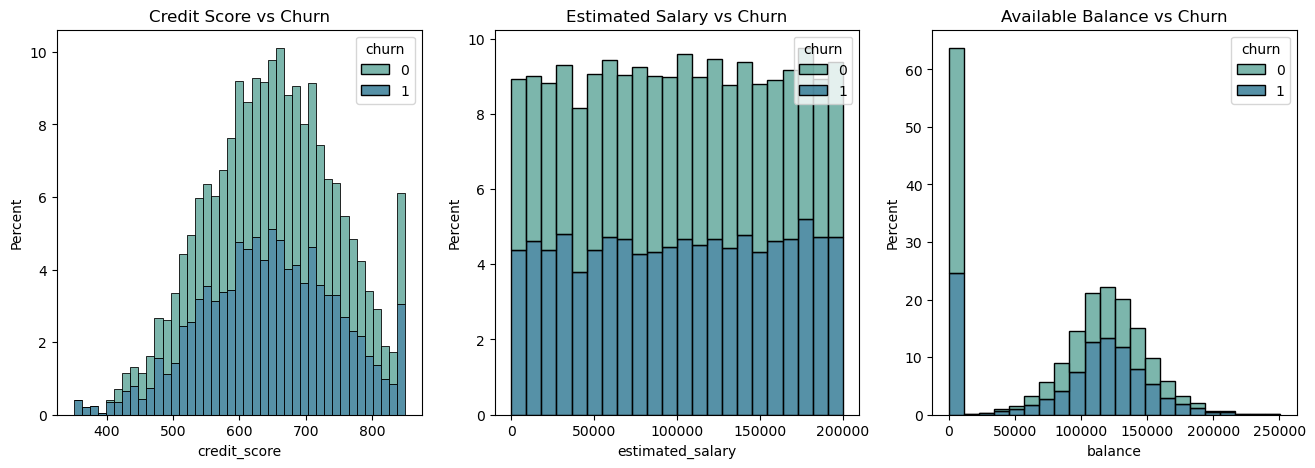

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
sns.histplot(data=df,
             x='credit_score',
             ax=axes[0],
             palette='crest',
             hue='churn',
             multiple='stack',
             stat='percent',
             common_norm=False)
axes[0].set_title('Credit Score vs Churn')

sns.histplot(data=df,
             x='estimated_salary',
             ax=axes[1],
             palette='crest',
             hue='churn',
             multiple='stack',
             stat='percent',
             common_norm=False)
axes[1].set_title('Estimated Salary vs Churn')

sns.histplot(data=df,
             x='balance',
             ax=axes[2],
             palette='crest',
             hue='churn',
             multiple='stack',
             stat='percent',
             common_norm=False)
axes[2].set_title('Available Balance vs Churn')

### Conclusion

As we can see, although **Estimated Salary** is a good predictor variable, the distribution of churned customers along all ranges is very similar, which means that the Bank cannot perform any countermeasure along a specific salary range.

However, both **Credit Scores** and **Available Balance** are good candidates for a hypothesis testing scenario, where we could select a sample of customers with $0 - $25,000 of Available balance and Credit Score between 600-700 and perform a treatment (exempt Bank fees for a determined period, upgrade their Credit Card without fee, etc.).

This was an important exercise for real-life problems where Modeling and Hypothesis Testing can be complementary and work together to prevent losses.